## Mitigatin the Fairness Issues using Pre-Processing: Removing Bais from Data

We can use the `CorrelationRemover` function in `Fairlearn` package for this purpose. It removes sensitive features from data and regresses out the sensitive features from non-sensitive features and uses the residuals as corrected features for bias.



In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, precision_score, roc_auc_score
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, equalized_odds_difference
from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio
import seaborn as sns
from fairlearn.preprocessing import CorrelationRemover

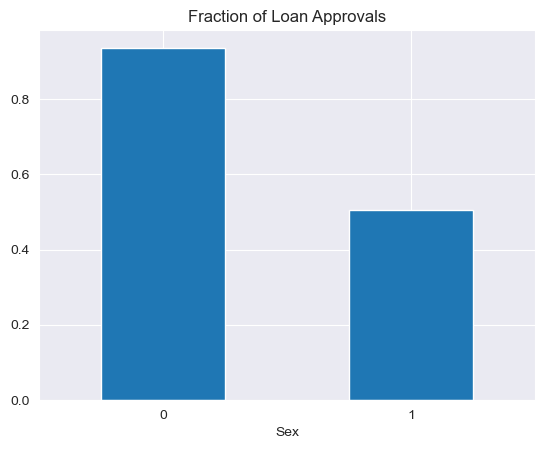

In [2]:
# Generate synthetic data
np.random.seed(42)
n = 1000

# Generate synthetic features:
# - Credit score (normally around 300-850)
# - Annual income in thousands (normally around mean of $50k with std dev of $15k)
# - Employment history in years (normally around 0-40)
X = pd.DataFrame({
    'Credit_Score': np.random.normal(650, 100, n),
    'Annual_Income_k': np.random.normal(50, 15, n),
    'Employment_History_y': np.random.normal(20, 10, n),
    'Interest_Rate': np.random.normal(5, 1, n),
    'Sex': np.random.choice([0, 1], n)  # 0 for 'Male', 1 for 'Female'
})

# Introduce a bias in the 'Interest_Rate' feature based on the sensitive attribute 'Sex'
X.loc[X['Sex'] == 1, 'Interest_Rate'] += 2  # Females have higher interest rates on average

# Introduce a strong bias in the label (loan approval) based on the sensitive attribute (sex)
threshold_male = 1.5  # A relatively low bar for males
threshold_female = 2.0  # A higher bar for females

# Calculate a synthetic loan approval decision based on the financial features and bias

y = pd.DataFrame({'Loan_Approval':np.zeros(X.shape[0])})
y.loc[(X['Sex'] == 0) & (X['Credit_Score']/650 + X['Annual_Income_k']/50 > threshold_male), 'Loan_Approval'] = 1
y.loc[(X['Sex'] == 1) & (X['Credit_Score']/650 + X['Annual_Income_k']/50 > threshold_female), 'Loan_Approval'] = 1

selection_rates = MetricFrame(
    metrics=selection_rate, y_true=y['Loan_Approval'], y_pred=y['Loan_Approval'], sensitive_features=X['Sex']
)

fig = selection_rates.by_group.plot.bar(
    legend=False, rot=0, title="Fraction of Loan Approvals"
)

We can visualize the possible correlation between senstive and non-sensitive features using a heatmap plot of correlations.

<Axes: >

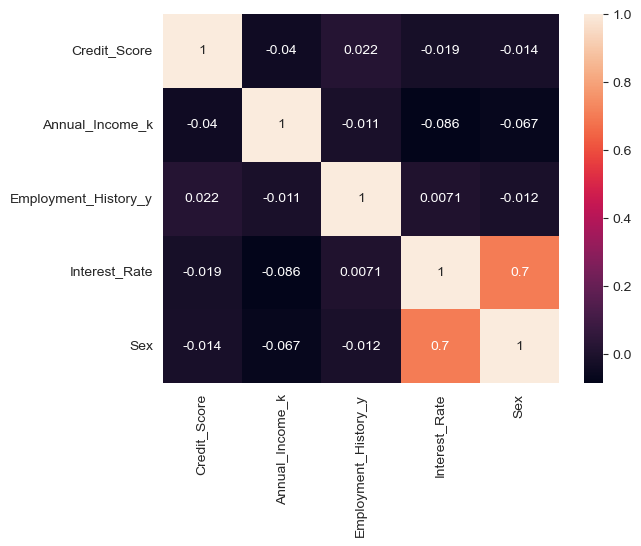

In [3]:
sns.heatmap(X.corr(), annot=True)

Then we can use the coorelartion remover to remove the bias from data. Mind that we fit it only on the training data and then transfom both training and test data.

<Axes: >

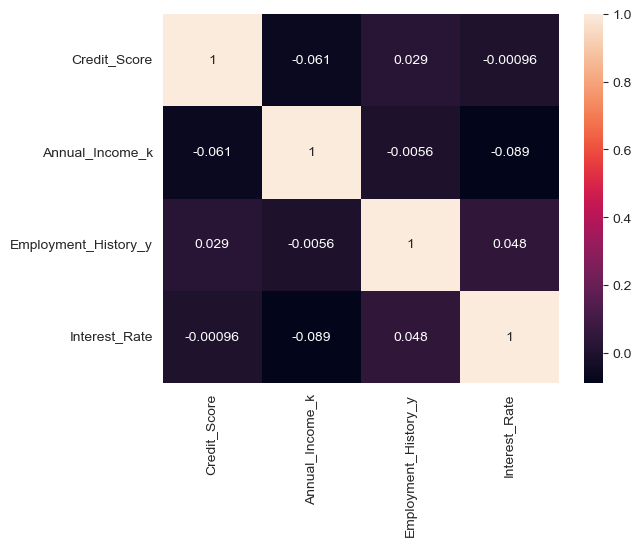

In [4]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sensitive_test = X_test['Sex']

cr = CorrelationRemover(sensitive_feature_ids=["Sex"], alpha=0.5)
X_train_cr = cr.fit_transform(X_train)

X_train_cr = pd.DataFrame(X_train_cr, columns=['Credit_Score','Annual_Income_k','Employment_History_y','Interest_Rate'])
X_test_cr = cr.transform(X_test)
X_test_cr = pd.DataFrame(X_test_cr, columns=['Credit_Score','Annual_Income_k','Employment_History_y','Interest_Rate'])

sns.heatmap(X_train_cr.corr(), annot=True)

In [5]:
# Train a Random forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_cr, y_train)
y_pred = clf.predict(X_test_cr)
y_pred_prob = clf.predict_proba(X_test_cr)[:,1]

# Measure accuracy
accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Measure AUC
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC: {auc}")

Accuracy: 0.7906746031746033
AUC: 0.9170386904761906


/Users/ghaithalseirawan/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


array([[<Axes: title={'center': 'accuracy'}, xlabel='Sex'>,
        <Axes: title={'center': 'precision'}, xlabel='Sex'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='Sex'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='Sex'>,
        <Axes: title={'center': 'selection rate'}, xlabel='Sex'>,
        <Axes: xlabel='Sex'>],
       [<Axes: xlabel='Sex'>, <Axes: xlabel='Sex'>, <Axes: xlabel='Sex'>]],
      dtype=object)

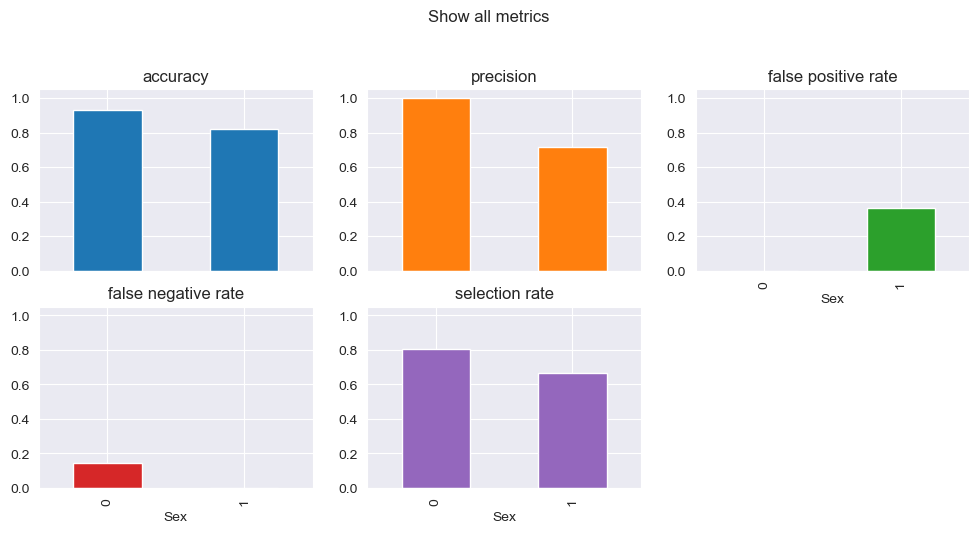

In [6]:
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)
# Analyze metrics using MetricFrame
metrics = {
    "accuracy": balanced_accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_test
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    ylim=[0,1.05],
    title="Show all metrics",
)

In [7]:

# Statistical Parity
stat_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity Difference: {stat_parity_diff}")

stat_parity_rto = demographic_parity_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity ratio: {stat_parity_rto}")

# Equalized Odds
equal_odds_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Difference: {equal_odds_diff}")

equal_odds_rto = equalized_odds_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Ratio: {equal_odds_rto}")

Statistical Parity Difference: 0.14102564102564108
Statistical Parity ratio: 0.8253968253968254
Equalized Odds Difference: 0.36
Equalized Odds Ratio: 0.0


**Exercise 4.3:** Try combining the preprocessing techniques, i.e, first resample the data and then apply the correlation remover. Report the results in comparison with two previous experiments.

Accuracy (Resampled): 0.8179563492063493
AUC (Resampled): 0.9011656746031745


/Users/ghaithalseirawan/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


array([[<Axes: title={'center': 'accuracy'}, xlabel='Sex'>,
        <Axes: title={'center': 'precision'}, xlabel='Sex'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='Sex'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='Sex'>,
        <Axes: title={'center': 'selection rate'}, xlabel='Sex'>,
        <Axes: xlabel='Sex'>],
       [<Axes: xlabel='Sex'>, <Axes: xlabel='Sex'>, <Axes: xlabel='Sex'>]],
      dtype=object)

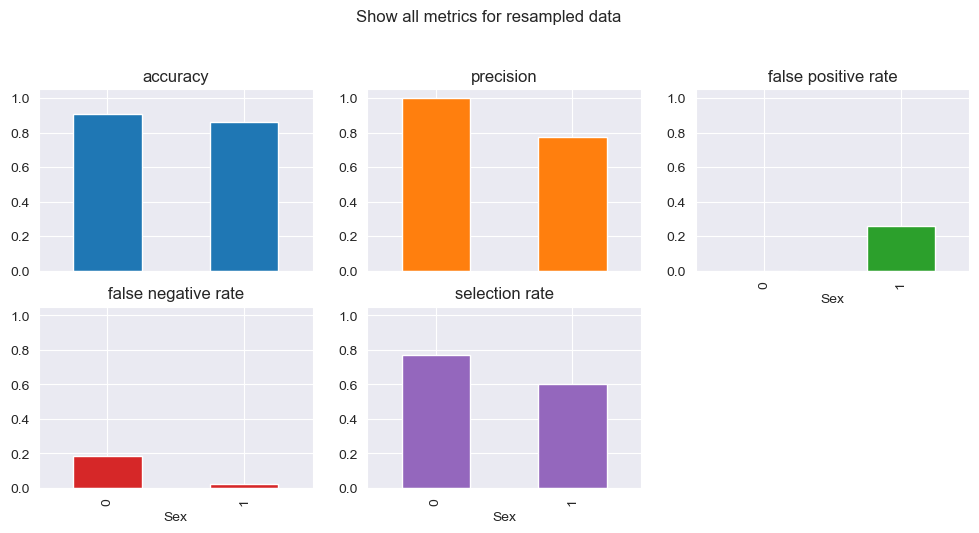

In [8]:

from imblearn.over_sampling import RandomOverSampler


ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)


cr_resampled = CorrelationRemover(sensitive_feature_ids=["Sex"], alpha=0.5)
X_train_resampled_cr = cr_resampled.fit_transform(X_train_resampled)
X_train_resampled_cr = pd.DataFrame(X_train_resampled_cr, columns=['Credit_Score', 'Annual_Income_k', 'Employment_History_y', 'Interest_Rate'])


X_test_resampled_cr = cr_resampled.transform(X_test)
X_test_resampled_cr = pd.DataFrame(X_test_resampled_cr, columns=['Credit_Score', 'Annual_Income_k', 'Employment_History_y', 'Interest_Rate'])


clf_resampled = RandomForestClassifier(random_state=42)
clf_resampled.fit(X_train_resampled_cr, y_train_resampled)
y_pred_resampled = clf_resampled.predict(X_test_resampled_cr)

accuracy_resampled = balanced_accuracy_score(y_test, y_pred_resampled)
print(f"Accuracy (Resampled): {accuracy_resampled}")


auc_resampled = roc_auc_score(y_test, clf_resampled.predict_proba(X_test_resampled_cr)[:, 1])
print(f"AUC (Resampled): {auc_resampled}")


metric_frame_resampled = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred_resampled, sensitive_features=sensitive_test
)
metric_frame_resampled.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    ylim=[0, 1.05],
    title="Show all metrics for resampled data"
)

In [9]:
print(f"Accuracy (Resampled): {accuracy_resampled}")

print(f"AUC (Resampled): {auc_resampled}")

Accuracy (Resampled): 0.8179563492063493
AUC (Resampled): 0.9011656746031745
